<a href="https://colab.research.google.com/github/kk-shetty/data_science_ik/blob/main/projects/ml_mini_project/node_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Mini Project - **Understanding Networks through Clustering**.
## Leveraging Local Node Features for Structural Profiling

## 1. Data Loading and Library Import

In this section, we import the necessary libraries and load the data into Google Colab from Google Drive. We use the `google.colab.drive` module to access files stored in Google Drive, and the `networkx` and `pandas` libraries for working with network data and data analysis, respectively.


In [1]:
# Importing necessary libraries
from google.colab import drive
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Mounting Google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading edge file
# file_url = '/content/drive/My Drive/ml_mini_project_data/soc-karate.txt'
file_url = '/content/drive/My Drive/ml_mini_project_data/facebook_combined.txt'
network = nx.read_edgelist(file_url)

In [4]:
# Basic details about the network
print("Number of nodes:", network.number_of_nodes())
print("Number of edges:", network.number_of_edges())

Number of nodes: 4039
Number of edges: 88234


In [5]:
# Only use for sample files with fewer than 500 nodes

# Plotting the network for visualization
# plt.figure(figsize=(6,6))
# pos = nx.fruchterman_reingold_layout(network)
# pos = nx.kamada_kawai_layout(network)
# pos = nx.random_layout(network)
# nx.draw(network, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='black', linewidths=1, font_size=10)
# plt.title("Graph Visualization")
# plt.show()

## 2. Extracting Local Features from the Network

In this section, we extract local features for each node in the network up to the fourth ego network (radius = 1 to 4). Local features capture the structural properties of the network neighborhood around each node, providing insights into its immediate connectivity and topology.

### Functions Used:

#### `extract_local_features(local_network, node, radius)`

This function computes various local features for a given node within its ego network of a specified radius. It calculates properties such as clustering coefficient, ego network size, density, number of triangles (closed triangles), number of bridges, centrality properties (radius, diameter, center), cycle basis count, and cycle counts of different lengths up to 6. The function returns a dictionary containing these features.

#### Usage:

We utilize the `extract_local_features` function to extract local features for each node in the network up to the fourth ego network. For each node, we iterate over ego networks of increasing radius, compute the local features using the function, and store the results in a dictionary.

### Steps:

1. **Iterate Over Nodes**: We iterate over each node in the network.
2. **Compute Local Features**: For each node, we compute local features within ego networks of radius 1 to 4 using the `extract_local_features` function.
3. **Create DataFrame**: We construct a pandas DataFrame from the computed local features dictionary, with nodes as rows and features as columns.

### Result:

The resulting DataFrame contains local features for each node, where each row represents a node and each column represents a local feature. This DataFrame serves as the basis for further analysis and modeling tasks, such as clustering nodes based on their structural similarities.

Let's take a sample of 20 rows from the DataFrame to examine the extracted local features.


In [6]:
# Using tqdm package to track the progress
from tqdm import tqdm

In [7]:
def extract_local_features(args):
    local_network, node, radius = args
    features = {}

    if radius == 1:
        features['node_clustering_coefficient'] = nx.clustering(local_network, node)

    features[f'EN{radius}_number_of_nodes'] = local_network.number_of_nodes()
    features[f'EN{radius}_number_of_edges'] = local_network.number_of_edges()
    features[f'EN{radius}_ego_density'] = nx.density(local_network)

    features[f'EN{radius}_triangles_count'] = sum(nx.triangles(local_network).values()) // 3

    features[f'EN{radius}_bridges_count'] = len(list(nx.bridges(local_network)))

    features[f'EN{radius}_is_center'] = 1 if node in nx.center(local_network) else 0
    features[f'EN{radius}_radius'] = nx.radius(local_network)
    features[f'EN{radius}_diameter'] = nx.diameter(local_network)

    cycle_basis_lengths = [len(cycle) for cycle in nx.cycle_basis(local_network)]
    features[f'EN{radius}_cycle_basis_count'] = len(cycle_basis_lengths)
    features[f'EN{radius}_max_cycle_basis'] = max(cycle_basis_lengths, default=0)

    return features

In [8]:
# Using the above function to extract the local featrures for 1st ego network and creating a data frame using all the features as columns.
def ego_network_features(ego_radius):
    local_features = {}

    for node in tqdm(network.nodes(), desc="Processing nodes", unit="node"):
        local_features[node] = {}
        ego_network = nx.ego_graph(network, node, radius=ego_radius)
        local_features[node].update(extract_local_features((ego_network, node, ego_radius)))

    # Creating pandas dataframe from the features dictionary and saving into csv
    df = pd.DataFrame.from_dict(local_features, orient='index')
    df.index.name = 'node'
    df.reset_index(inplace=True)

    # Specify the path where you want to save the file in your Google Drive
    file_path = f'/content/drive/My Drive/ml_mini_project_data/facebook_combined_output_{ego_radius}.csv'

    # Save the DataFrame to CSV without row index
    df.to_csv(file_path, index=False)

In [9]:
# Calling the function to extract local features of different ego network.
# ego_network_features(1)
# ego_network_features(2)
# ego_network_features(3)
# ego_network_features(4)

In [10]:
# Creating df from individual ego network feature csv file

df1 = pd.read_csv('/content/drive/My Drive/ml_mini_project_data/facebook_combined_output_1.csv')
df2 = pd.read_csv('/content/drive/My Drive/ml_mini_project_data/facebook_combined_output_2.csv')
df3 = pd.read_csv('/content/drive/My Drive/ml_mini_project_data/facebook_combined_output_3.csv')
df4 = pd.read_csv('/content/drive/My Drive/ml_mini_project_data/facebook_combined_output_4.csv')

## 3. Feature Engineering

In [11]:
# Checking unique values for each of the features in each data frames and removing features with constand values
df1.nunique()

node                           4039
node_clustering_coefficient    2540
EN1_number_of_nodes             227
EN1_number_of_edges            1586
EN1_ego_density                2552
EN1_triangles_count            2422
EN1_bridges_count                12
EN1_is_center                     1
EN1_radius                        1
EN1_diameter                      2
EN1_cycle_basis_count          1559
EN1_max_cycle_basis              21
dtype: int64

In [12]:
# Check the distribution of EN1_diameter
df1.EN1_diameter.value_counts()

EN1_diameter
2    3697
1     342
Name: count, dtype: int64

In [13]:
df1.drop(columns=['EN1_is_center', 'EN1_radius'], inplace=True)

In [14]:
df2.nunique()

node                     4039
EN2_number_of_nodes       361
EN2_number_of_edges       501
EN2_ego_density           513
EN2_triangles_count       507
EN2_bridges_count          24
EN2_cycle_basis_count     501
EN2_max_cycle_basis        79
dtype: int64

In [15]:
df3.nunique()

node                     4039
EN3_number_of_nodes        63
EN3_number_of_edges        64
EN3_ego_density            64
EN3_triangles_count        64
EN3_bridges_count          28
EN3_cycle_basis_count      62
EN3_max_cycle_basis        31
dtype: int64

In [16]:
df4.nunique()

node                   4039
EN4_number_of_nodes      24
EN4_number_of_edges      24
EN4_ego_density          24
EN4_triangles_count      24
EN4_bridges_count        17
dtype: int64

In [17]:
# Performing correlation analysis between features of the each ego network

# Importing seaborn library to plot correlation matrix
import seaborn as sns

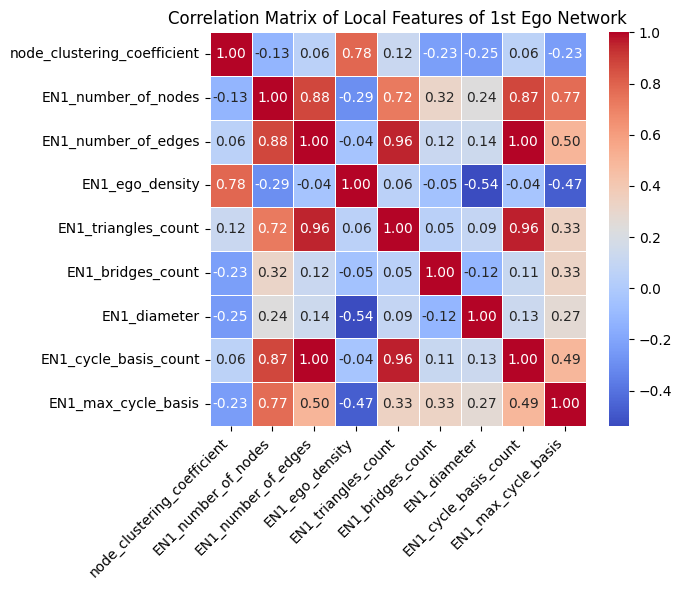

In [18]:
# Correlation matrics for 1st ego network features
plt.figure(figsize=(7, 6))
heatmap = sns.heatmap(df1.iloc[:,1:].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlation Matrix of Local Features of 1st Ego Network')
plt.tight_layout()
plt.show()

In [19]:
# There is high correlation between below combinations:
# 1. EN1_number_of_edges and EN1_triangles_count
# 2. EN1_number_of_edges and EN1_cycle_basis_count
df1.drop(columns=['EN1_triangles_count','EN1_cycle_basis_count'], inplace=True)

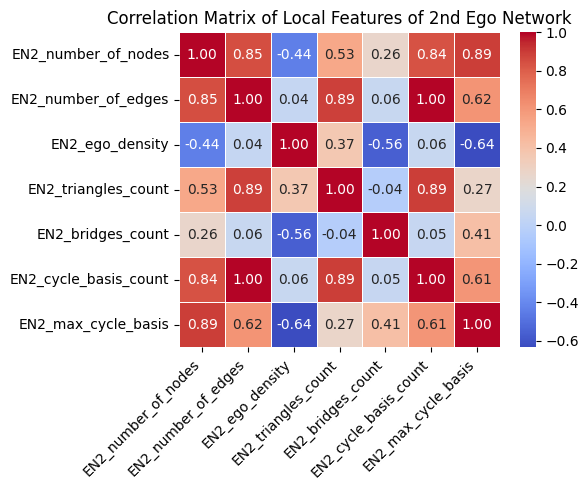

In [20]:
# Correlation matrics for 2nd ego network features
plt.figure(figsize=(6, 5))
heatmap = sns.heatmap(df2.iloc[:,1:].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlation Matrix of Local Features of 2nd Ego Network')
plt.tight_layout()
plt.show()

In [21]:
# There is high correlation between below combinations:
# 1. EN2_number_of_edges and EN2_triangles_count
# 2. EN2_number_of_edges and EN2_cycle_basis_count
# 2. EN2_number_of_nodes and EN2_max_cycle_basis
df2.drop(columns=['EN2_triangles_count','EN2_cycle_basis_count','EN2_max_cycle_basis'], inplace=True)

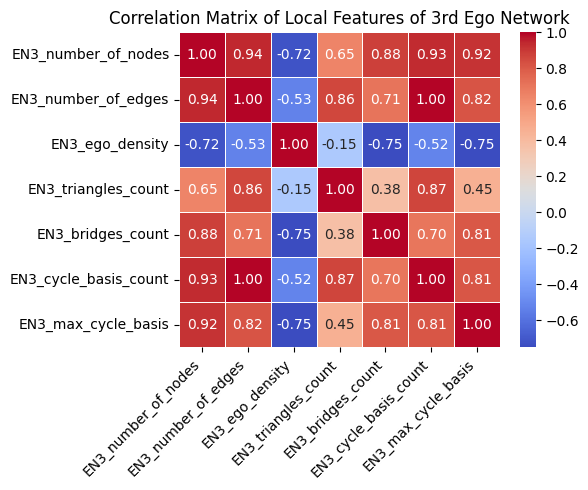

In [22]:
# Correlation matrics for 3rd ego network features
plt.figure(figsize=(6, 5))
heatmap = sns.heatmap(df3.iloc[:,1:].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlation Matrix of Local Features of 3rd Ego Network')
plt.tight_layout()
plt.show()

In [23]:
# There is high correlation between below combinations:
# 1. EN3_number_of_edges and EN3_cycle_basis_count
# 2. EN3_number_of_nodes and EN3_max_cycle_basis
df3.drop(columns=['EN3_cycle_basis_count','EN3_max_cycle_basis'], inplace=True)

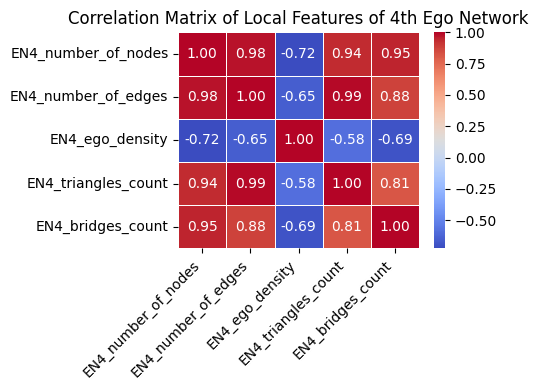

In [24]:
# Correlation matrics for 4th ego network features
plt.figure(figsize=(5, 4))
heatmap = sns.heatmap(df4.iloc[:,1:].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlation Matrix of Local Features of 4th Ego Network')
plt.tight_layout()
plt.show()

In [25]:
# There is high correlation between below combinations:
# 1. EN4_number_of_edges and EN4_triangles_count
# 2. EN4_number_of_nodes and EN4_bridges_count
df4.drop(columns=['EN4_triangles_count','EN4_bridges_count'], inplace=True)

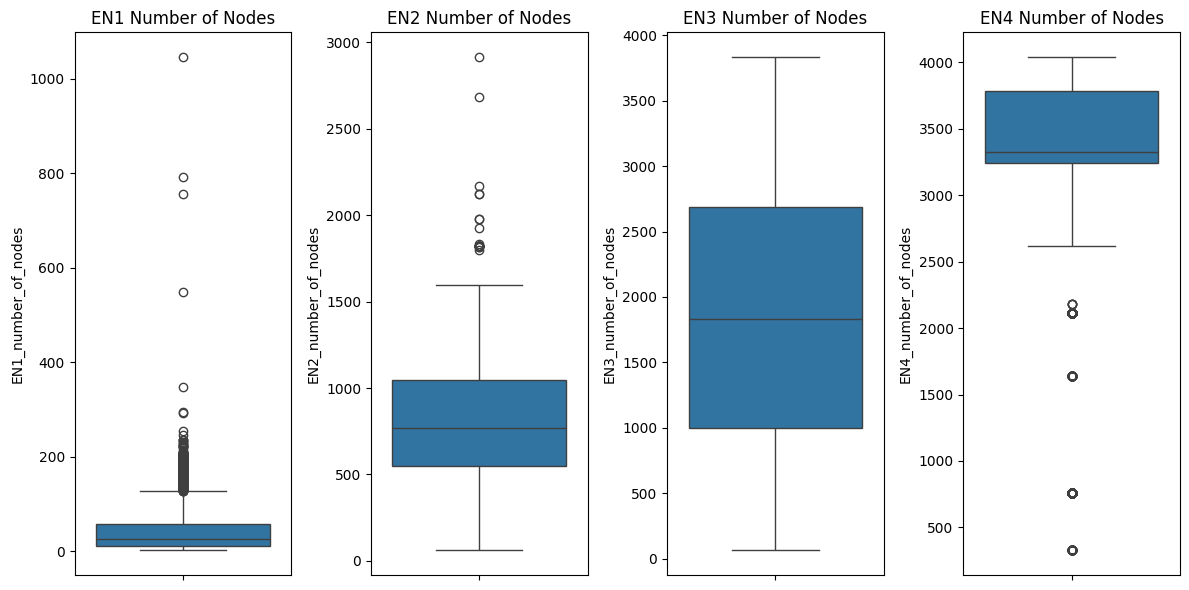

In [26]:
# Checking for outliers

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(12, 6))

# Plot ego_net_1
axs[0].set_title("EN1 Number of Nodes")
sns.boxplot(df1['EN1_number_of_nodes'], ax=axs[0])

# Plot ego_net_2
axs[1].set_title("EN2 Number of Nodes")
sns.boxplot(df2['EN2_number_of_nodes'], ax=axs[1])

# Plot ego_net_3
axs[2].set_title("EN3 Number of Nodes")
sns.boxplot(df3['EN3_number_of_nodes'], ax=axs[2])

# Plot ego_net_4
axs[3].set_title("EN4 Number of Nodes")
sns.boxplot(df4['EN4_number_of_nodes'], ax=axs[3])

plt.tight_layout()
plt.show()

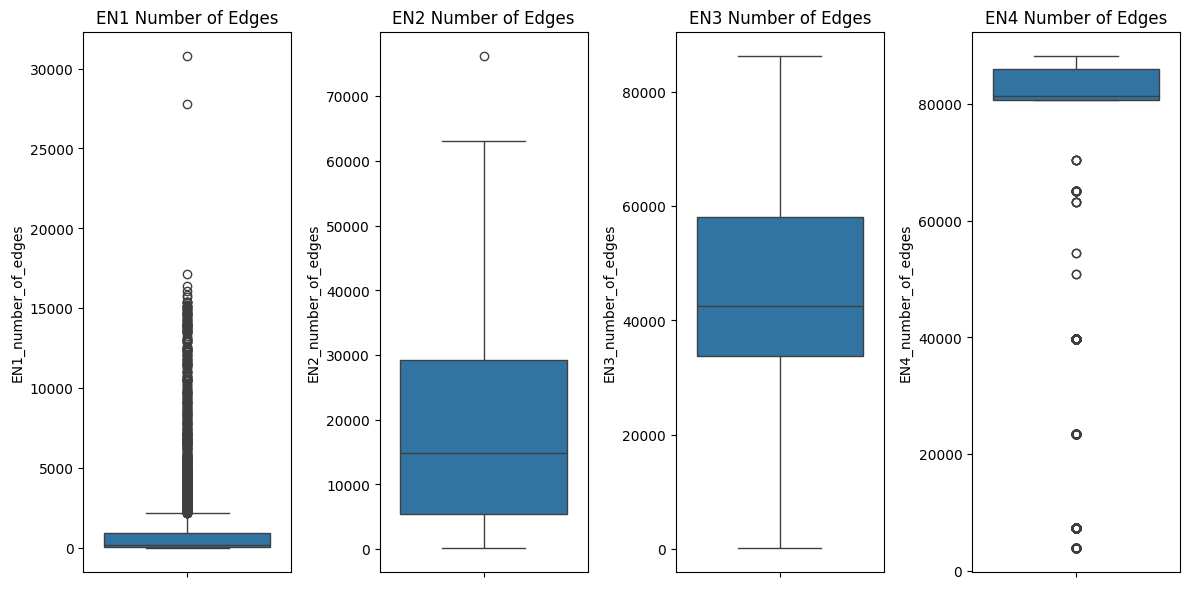

In [27]:
# Checking for outliers

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(12, 6))

# Plot ego_net_1
axs[0].set_title("EN1 Number of Edges")
sns.boxplot(df1['EN1_number_of_edges'], ax=axs[0])

# Plot ego_net_2
axs[1].set_title("EN2 Number of Edges")
sns.boxplot(df2['EN2_number_of_edges'], ax=axs[1])

# Plot ego_net_3
axs[2].set_title("EN3 Number of Edges")
sns.boxplot(df3['EN3_number_of_edges'], ax=axs[2])

# Plot ego_net_4
axs[3].set_title("EN4 Number of Edges")
sns.boxplot(df4['EN4_number_of_edges'], ax=axs[3])

plt.tight_layout()
plt.show()

In [28]:
# Feature scaling : Since ego_density is in the scale of 0 to 1, it would be ideal to scale rest of the features to the same scale usin g min max scaling.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [29]:
# Ego network 1 features
features_to_scale = ['EN1_number_of_nodes', 'EN1_number_of_edges', 'EN1_bridges_count', 'EN1_max_cycle_basis']
# Fit and transform the selected features
scaled_features = scaler.fit_transform(df1[features_to_scale])
# Convert scaled features to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=[feat + '_scaled' for feat in features_to_scale])
# Append the scaled features to the original DataFrame
df1 = pd.concat([df1, scaled_df], axis=1)

In [30]:
# Ego network 2 features
features_to_scale = ['EN2_number_of_nodes', 'EN2_number_of_edges', 'EN2_bridges_count']
# Fit and transform the selected features
scaled_features = scaler.fit_transform(df2[features_to_scale])
# Convert scaled features to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=[feat + '_scaled' for feat in features_to_scale])
# Append the scaled features to the original DataFrame
df2 = pd.concat([df2, scaled_df], axis=1)

In [31]:
# Ego network 3 features
features_to_scale = ['EN3_number_of_nodes', 'EN3_number_of_edges', 'EN3_triangles_count', 'EN3_bridges_count']
# Fit and transform the selected features
scaled_features = scaler.fit_transform(df3[features_to_scale])
# Convert scaled features to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=[feat + '_scaled' for feat in features_to_scale])
# Append the scaled features to the original DataFrame
df3 = pd.concat([df3, scaled_df], axis=1)

In [32]:
# Ego network 4 features
features_to_scale = ['EN4_number_of_nodes', 'EN4_number_of_edges']
# Fit and transform the selected features
scaled_features = scaler.fit_transform(df4[features_to_scale])
# Convert scaled features to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=[feat + '_scaled' for feat in features_to_scale])
# Append the scaled features to the original DataFrame
df4 = pd.concat([df4, scaled_df], axis=1)

In [33]:
# Concatinating all the 4 dfs into a single df and then performing overall correlation analysis (on scaled features)
merged_df = pd.merge(df1, df2, on='node', how='inner')
merged_df = pd.merge(merged_df, df3, on='node', how='inner')
merged_df = pd.merge(merged_df, df4, on='node', how='inner')

In [34]:
merged_df.sample(5)

,node,node_clustering_coefficient,EN1_number_of_nodes,EN1_number_of_edges,EN1_ego_density,EN1_bridges_count,EN1_diameter,EN1_max_cycle_basis,EN1_number_of_nodes_scaled,EN1_number_of_edges_scaled,...,EN3_bridges_count,EN3_number_of_nodes_scaled,EN3_number_of_edges_scaled,EN3_triangles_count_scaled,EN3_bridges_count_scaled,EN4_number_of_nodes,EN4_number_of_edges,EN4_ego_density,EN4_number_of_nodes_scaled,EN4_number_of_edges_scaled
170,170,0.471498,47,534,0.493987,0,2,5,0.043103,0.017317,...,25,0.386044,0.389120,0.315068,0.290323,3261,80997,0.015238,0.790409,0.914174
2228,2588,0.702808,92,2969,0.709269,0,2,5,0.086207,0.096429,...,18,0.501990,0.706893,0.882755,0.177419,3270,81021,0.015159,0.792834,0.914459
668,1182,0.646154,67,1452,0.656716,0,2,5,0.062261,0.047143,...,50,0.848236,0.939010,0.984769,0.693548,3780,86055,0.012049,0.930226,0.974159
705,1219,0.648498,55,982,0.661279,0,2,5,0.050766,0.031872,...,43,0.695941,0.672405,0.506848,0.580645,3780,86055,0.012049,0.930226,0.974159
2633,3093,0.508333,17,77,0.566176,0,2,3,0.014368,0.002469,...,18,0.468825,0.492514,0.363544,0.177419,3327,81366,0.014706,0.808190,0.918550


In [35]:
merged_df.nunique()

node                           4039
node_clustering_coefficient    2540
EN1_number_of_nodes             227
EN1_number_of_edges            1586
EN1_ego_density                2552
EN1_bridges_count                12
EN1_diameter                      2
EN1_max_cycle_basis              21
EN1_number_of_nodes_scaled      227
EN1_number_of_edges_scaled     1586
EN1_bridges_count_scaled         12
EN1_max_cycle_basis_scaled       21
EN2_number_of_nodes             361
EN2_number_of_edges             501
EN2_ego_density                 513
EN2_bridges_count                24
EN2_number_of_nodes_scaled      361
EN2_number_of_edges_scaled      501
EN2_bridges_count_scaled         24
EN3_number_of_nodes              63
EN3_number_of_edges              64
EN3_ego_density                  64
EN3_triangles_count              64
EN3_bridges_count                28
EN3_number_of_nodes_scaled       63
EN3_number_of_edges_scaled       64
EN3_triangles_count_scaled       64
EN3_bridges_count_scaled    

In [36]:
# List of scaled features
scaled_features = ['node_clustering_coefficient','EN1_ego_density', 'EN1_number_of_nodes_scaled', 'EN1_number_of_edges_scaled', 'EN1_bridges_count_scaled', 'EN1_max_cycle_basis_scaled']
scaled_features.extend(['EN2_ego_density','EN2_number_of_nodes_scaled', 'EN2_number_of_edges_scaled', 'EN2_bridges_count_scaled'])
scaled_features.extend(['EN3_ego_density','EN3_number_of_nodes_scaled', 'EN3_number_of_edges_scaled', 'EN3_triangles_count_scaled', 'EN3_bridges_count_scaled'])
scaled_features.extend(['EN4_ego_density','EN4_number_of_nodes_scaled', 'EN4_number_of_edges_scaled'])

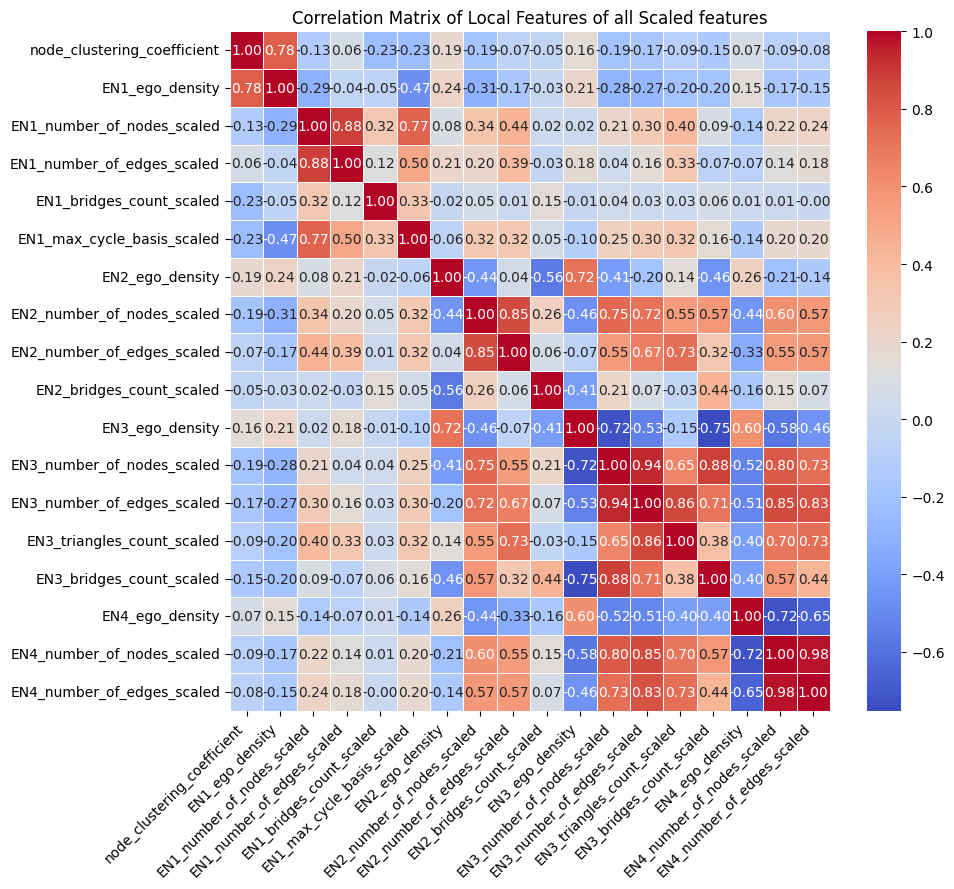

In [37]:
# Correlation metrics for all 4 ego network features
features = []
plt.figure(figsize=(10, 9))
heatmap = sns.heatmap(merged_df[scaled_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlation Matrix of Local Features of all Scaled features')
plt.tight_layout()
plt.show()

In [38]:
# Since number of nodes and number of edges are very relavant and key features for the model, we keep both these features for all the ego networks even though there is high correlation between them

## 4. Clustering

In [39]:
# Import necessary libraries
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [40]:
# Finding the best value number of clusters

In [41]:
# Calculate inertia for different values of K
inertia = []
for k in range(1, 51):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(merged_df[scaled_features])
    inertia.append(kmeans.inertia_)

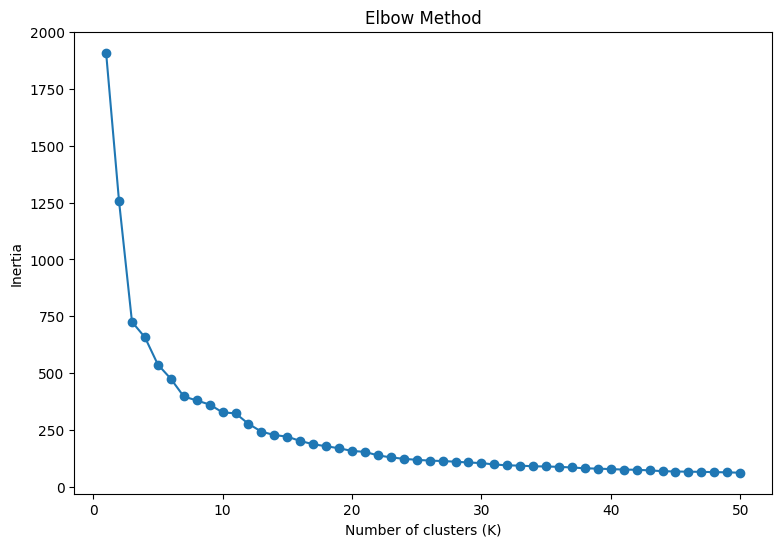

In [42]:
# Plot the elbow curve
plt.figure(figsize=(9, 6))
plt.plot(range(1, 51), inertia, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [52]:

# Initialize variables to store silhouette scores and the best K
best_score = -1
best_k = None

# Define the range of K values to explore
min_k = 2
max_k = 100

# Iterate over different values of K
for k in range(min_k, max_k + 1):
    # Fit KMeans clustering model
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = kmeans.fit_predict(merged_df[scaled_features])

    # Calculate silhouette score
    score = silhouette_score(merged_df[scaled_features], labels)

    # Update the best silhouette score and best K if needed
    if score > best_score:
        best_score = score
        best_k = k

print(f"Best Silhouette Score: {best_score} (K={best_k})")

Best Silhouette Score: 0.439886091237996 (K=31)


In [53]:
# From the elbow analysis we can see that best value for K is at 31
num_clusters = 31

In [54]:
# Apply clustering algorithms
# K-means
kmeans = KMeans(n_clusters=num_clusters, n_init='auto', random_state=42)
kmeans_labels = kmeans.fit_predict(merged_df[scaled_features])

# Hierarchical clustering
agg_clustering = AgglomerativeClustering(n_clusters=5)
agg_labels = agg_clustering.fit_predict(merged_df[scaled_features])

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(merged_df[scaled_features])

In [63]:
# list of Raw features:
en1_raw_features = ['node_clustering_coefficient', 'EN1_number_of_nodes', 'EN1_number_of_edges', 'EN1_ego_density', 'EN1_bridges_count', 'EN1_diameter', 'EN1_max_cycle_basis',
                    'EN2_number_of_nodes', 'EN2_number_of_edges', 'EN2_ego_density', 'EN2_bridges_count',
                    'EN3_number_of_nodes', 'EN3_number_of_edges', 'EN3_ego_density', 'EN3_triangles_count', 'EN3_bridges_count',
                    'EN4_number_of_nodes', 'EN4_number_of_edges', 'EN4_ego_density']

In [58]:
# Evaluate clustering performance on scaled features
kmeans_silhouette = silhouette_score(merged_df[scaled_features], kmeans_labels)
agg_silhouette = silhouette_score(merged_df[scaled_features], agg_labels)
dbscan_silhouette = silhouette_score(merged_df[scaled_features], dbscan_labels)

kmeans_ch_score = calinski_harabasz_score(merged_df[scaled_features], kmeans_labels)
agg_ch_score = calinski_harabasz_score(merged_df[scaled_features], agg_labels)
dbscan_ch_score = calinski_harabasz_score(merged_df[scaled_features], dbscan_labels)

kmeans_db_score = davies_bouldin_score(merged_df[scaled_features], kmeans_labels)
agg_db_score = davies_bouldin_score(merged_df[scaled_features], agg_labels)
dbscan_db_score = davies_bouldin_score(merged_df[scaled_features], dbscan_labels)

In [61]:
# Print evaluation metrics
print("K-means Silhouette Score:", kmeans_silhouette)
print("Agglomerative Clustering Silhouette Score:", agg_silhouette)
print("DBSCAN Silhouette Score:", dbscan_silhouette)
print('\n')
print("K-means Calinski-Harabasz Score:", kmeans_ch_score)
print("Agglomerative Clustering Calinski-Harabasz Score:", agg_ch_score)
print("DBSCAN Calinski-Harabasz Score:", dbscan_ch_score)
print('\n')
print("K-means Davies-Bouldin Score:", kmeans_db_score)
print("Agglomerative Clustering Davies-Bouldin Score:", agg_db_score)
print("DBSCAN Davies-Bouldin Score:", dbscan_db_score)

K-means Silhouette Score: 0.439886091237996
Agglomerative Clustering Silhouette Score: 0.37978773212763994
DBSCAN Silhouette Score: 0.10870798963849733


K-means Calinski-Harabasz Score: 2466.577540509442
Agglomerative Clustering Calinski-Harabasz Score: 2536.3732586774854
DBSCAN Calinski-Harabasz Score: 55.45451104546282


K-means Davies-Bouldin Score: 0.8095715640234148
Agglomerative Clustering Davies-Bouldin Score: 0.9296615213987046
DBSCAN Davies-Bouldin Score: 1.1302700211798034


In [64]:
# Evaluate clustering performance on raw features
kmeans_silhouette = silhouette_score(merged_df[en1_raw_features], kmeans_labels)
agg_silhouette = silhouette_score(merged_df[en1_raw_features], agg_labels)
dbscan_silhouette = silhouette_score(merged_df[en1_raw_features], dbscan_labels)

kmeans_ch_score = calinski_harabasz_score(merged_df[en1_raw_features], kmeans_labels)
agg_ch_score = calinski_harabasz_score(merged_df[en1_raw_features], agg_labels)
dbscan_ch_score = calinski_harabasz_score(merged_df[en1_raw_features], dbscan_labels)

kmeans_db_score = davies_bouldin_score(merged_df[en1_raw_features], kmeans_labels)
agg_db_score = davies_bouldin_score(merged_df[en1_raw_features], agg_labels)
dbscan_db_score = davies_bouldin_score(merged_df[en1_raw_features], dbscan_labels)

In [65]:
# Print evaluation metrics
print("K-means Silhouette Score:", kmeans_silhouette)
print("Agglomerative Clustering Silhouette Score:", agg_silhouette)
print("DBSCAN Silhouette Score:", dbscan_silhouette)
print('\n')
print("K-means Calinski-Harabasz Score:", kmeans_ch_score)
print("Agglomerative Clustering Calinski-Harabasz Score:", agg_ch_score)
print("DBSCAN Calinski-Harabasz Score:", dbscan_ch_score)
print('\n')
print("K-means Davies-Bouldin Score:", kmeans_db_score)
print("Agglomerative Clustering Davies-Bouldin Score:", agg_db_score)
print("DBSCAN Davies-Bouldin Score:", dbscan_db_score)

K-means Silhouette Score: -0.09511104749218399
Agglomerative Clustering Silhouette Score: 0.27886967143119595
DBSCAN Silhouette Score: -0.447784943522514


K-means Calinski-Harabasz Score: 11619.146077770432
Agglomerative Clustering Calinski-Harabasz Score: 4180.575923440555
DBSCAN Calinski-Harabasz Score: 24.690225791526952


K-means Davies-Bouldin Score: 4.989206723455739
Agglomerative Clustering Davies-Bouldin Score: 3.3740510026504658
DBSCAN Davies-Bouldin Score: 3.6536922139908676


In [44]:
# Initialize KMeans model
kmeans = KMeans(n_clusters=num_clusters, n_init='auto', random_state=42)

# Fit the model to your data
kmeans.fit(merged_df[scaled_features])

# Obtain cluster assignments
cluster_assignments = kmeans.predict(merged_df[scaled_features])

# Add cluster assignments to your DataFrame
merged_df['cluster'] = cluster_assignments

In [46]:
# Distribution of nodes in each cluster
merged_df.cluster.value_counts()

cluster
1    1047
3     504
7     439
6     390
4     320
5     312
8     302
0     272
9     256
2     197
Name: count, dtype: int64

In [47]:
# Analyze cluster characteristics

#1 - Cluster Centroids: The centroid of a cluster represents the mean feature values of the data points within that cluster. Cluster centroids provide insight into the average behavior or characteristics of the data points within each cluster. They serve as representative points for the cluster and can help characterize the cluster's central tendency in feature space.
#   Features for Cluster centroid
en1_raw_features = ['node_clustering_coefficient', 'EN1_number_of_nodes', 'EN1_number_of_edges', 'EN1_ego_density', 'EN1_bridges_count', 'EN1_diameter', 'EN1_max_cycle_basis', 'cluster']
en2_raw_features = ['EN2_number_of_nodes', 'EN2_number_of_edges', 'EN2_ego_density', 'EN2_bridges_count', 'cluster']
en3_raw_features = ['EN3_number_of_nodes', 'EN3_number_of_edges', 'EN3_ego_density', 'EN3_triangles_count', 'EN3_bridges_count', 'cluster']
en4_raw_features = ['EN4_number_of_nodes', 'EN4_number_of_edges', 'EN4_ego_density', 'cluster']

In [48]:
# Cluster centroid for ego network 1
merged_df[en1_raw_features].groupby('cluster').mean()

,node_clustering_coefficient,EN1_number_of_nodes,EN1_number_of_edges,EN1_ego_density,EN1_bridges_count,EN1_diameter,EN1_max_cycle_basis
cluster,,,,,,,
0,0.532569,33.680147,446.816176,0.598675,0.025735,1.974265,4.650735
1,0.568504,56.938873,1387.066858,0.607668,0.052531,1.949379,5.410697
2,0.648124,15.619289,110.675127,0.737064,0.045685,1.791878,3.421320
3,0.585846,32.837302,471.956349,0.629605,0.000000,2.000000,4.378968
4,0.462857,24.409375,197.734375,0.572181,0.081250,1.946875,4.131250
5,0.581265,78.583333,2423.657051,0.601721,0.025641,1.977564,6.240385
6,0.879964,10.879487,70.910256,0.906684,0.000000,1.707692,3.094872
7,0.336720,43.138952,539.492027,0.449428,0.116173,1.929385,5.425968
8,0.810831,111.175497,6877.738411,0.820066,0.000000,1.947020,5.450331


In [49]:
# Cluster centroid for ego network 2
merged_df[en2_raw_features].groupby('cluster').mean()

,EN2_number_of_nodes,EN2_number_of_edges,EN2_ego_density,EN2_bridges_count
cluster,,,,
0,758.426471,30793.786765,0.107234,7.889706
1,1097.531996,28934.340019,0.048676,11.429799
2,141.269036,1385.715736,0.121932,3.395939
3,611.555556,10296.827381,0.056464,7.855159
4,512.615625,5001.100000,0.041984,12.409375
5,641.480769,20349.769231,0.087084,7.352564
6,452.717949,6663.228205,0.070158,9.333333
7,712.159453,12543.626424,0.049705,7.371298
8,756.218543,30781.241722,0.107797,7.990066


In [50]:
# Cluster centroid for ego network 3
merged_df[en3_raw_features].groupby('cluster').mean()

,EN3_number_of_nodes,EN3_number_of_edges,EN3_ego_density,EN3_triangles_count,EN3_bridges_count
cluster,,,,,
0,1038.294118,34301.095588,0.064830,9.705674e+05,8.544118
1,2775.221585,60843.681948,0.015823,8.986181e+05,44.331423
2,169.959391,1499.208122,0.094608,7.333782e+03,7.000000
3,1699.825397,38979.353175,0.027320,5.488545e+05,20.884921
4,706.043750,6926.590625,0.028109,3.498612e+04,18.284375
5,2198.698718,63506.243590,0.026948,1.427923e+06,28.839744
6,1594.712821,36236.071795,0.028917,5.221665e+05,22.828205
7,1778.879271,41017.849658,0.026053,5.701931e+05,19.594533
8,1006.178808,34026.208609,0.067405,9.692695e+05,7.139073


In [51]:
# Cluster centroid for ego network 4
merged_df[en4_raw_features].groupby('cluster').mean()

,EN4_number_of_nodes,EN4_number_of_edges,EN4_ego_density
cluster,,,
0,3238.000000,80703.000000,0.015399
1,3787.341929,86092.330468,0.012008
2,636.228426,6391.593909,0.039060
3,3389.781746,81518.753968,0.014274
4,2079.387500,38584.746875,0.017762
5,3476.342949,82908.932692,0.013913
6,3430.146154,82433.405128,0.014151
7,3344.143508,80905.430524,0.014510
8,3238.000000,80703.000000,0.015399
